New to pyTorch, as usual, wanted to learn by doing things from scratch. Below are a few blogs that got me going.

Number 1, really from scratch
https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e?#3a3f

ImageRNN but it is using nn.RNN, I wanted even lower..
https://medium.com/dair-ai/building-rnns-is-fun-with-pytorch-and-google-colab-3903ea9a3a79

PyTorch - Tutorial that set me thingking
https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html
https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html


In [1]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
BATCH_SIZE = 64

# list all transformations
transform = transforms.Compose(
    [transforms.ToTensor()])
# download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2,drop_last=True)

# download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2,drop_last=True)

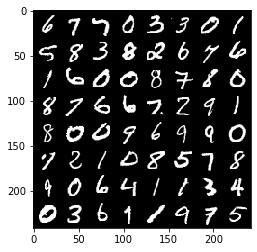

In [4]:
# functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [14]:
N_INPUTS = 28*28 #image size is 28x28 and one input so, flatten it to 1D 
N_HIDDEN = 64 #hidden state 
N_OUTPUTS = 10 #0-#9
N_EPHOCS = 10

In [17]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [16]:
#accuracy calculations
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [55]:
#modified this class from the pyTorch tutorial #1
class RNN(nn.Module):

    # you can also accept arguments in your model constructor
    def __init__(self, data_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        input_size = data_size + hidden_size #to note the size of input

        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2o = nn.Linear(input_size, output_size)    #we may use hidden size alone
        
        self.softmax = nn.LogSoftmax(dim=1) #0-9 categories
    def forward(self, data,hidden):
        combined = torch.cat((data, hidden), 1)  #combine two inputs
        hidden = self.i2h(combined)
        output = self.h2o(combined)              #we may use hidden alone
        output = self.softmax(output)
        return hidden, output 
    def init_hidden(self):
        return torch.zeros(BATCH_SIZE,self.hidden_size) #batch size X hidden size

In [56]:
rnnmodel = RNN(N_INPUTS,N_HIDDEN,N_OUTPUTS).to(device)
rnnmodel

RNN(
  (i2h): Linear(in_features=848, out_features=64, bias=True)
  (h2o): Linear(in_features=848, out_features=10, bias=True)
  (softmax): LogSoftmax()
)

In [57]:
#optimizer and loss func
import torch.optim as optim

lr=0.001
optimizer = torch.optim.SGD(rnnmodel.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()

In [68]:
all_losses=[]
all_accuracy=[]
N_EPHOCS=100
print('Epochs # ' ,end='')
for epoch in range(N_EPHOCS):  # loop over the dataset multiple times
    train_running_loss = 0.0
    train_acc = 0.0
    rnnmodel.train()
    # TRAINING ROUND
    for i, data in enumerate(trainloader):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        hidden = rnnmodel.init_hidden() 
        hidden = hidden.to(device)
        
        # get the inputs
        inputs, labels = data
              
        inputs = inputs.view(-1, 28*28).to(device) 

        # forward + backward + optimize
        outputs,hidden = rnnmodel(inputs,hidden)
        
        outputs = outputs.to(device)
        hidden = hidden.to(device)
        
        labels = labels.to(device)
        loss = loss_func(outputs, labels)
        
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
    rnnmodel.eval()
    print('%d '%( epoch),end='')
    all_losses.append(train_running_loss / i)
    all_accuracy.append(train_acc/i)

Epochs # 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [69]:
test_acc = 0.0

for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, 28*28).to(device)
    hidden = rnnmodel.init_hidden().to(device) 
    labels = labels.to(device)

    outputs,hidden = rnnmodel(inputs,hidden)

    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 91.76


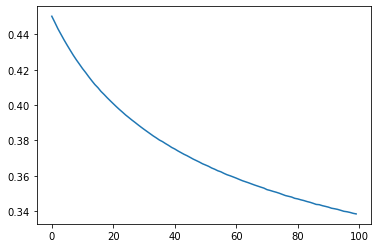

In [72]:
#plot the losses
plt.plot(np.array(all_losses))
plt.show()

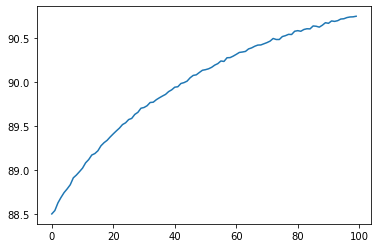

In [73]:
#plot the accuracy
plt.plot(np.array(all_accuracy))
plt.show()

In [66]:
#predict is another matter altogether, make a dummy hidden with size of inout
t=inputs[0:15].view(-1, 28*28).to(device)
h =torch.zeros(t.size(0),64).to(device)

In [67]:
#model returns ouput nad hidden, ignore hidden. output is size of batch,take the max and round it
o,h=rnnmodel(t,h)
#compare predicted vs original
print(torch.max(o, 1)[1].data)
print(labels[0:15])

tensor([8, 6, 4, 1, 9, 2, 8, 4, 4, 7, 0, 1, 9, 2, 8], device='cuda:0')
tensor([8, 6, 4, 1, 9, 3, 8, 4, 4, 7, 0, 1, 9, 2, 8], device='cuda:0')


In [ ]:
[code]
import torchimport torch.nn as nn
import torchvision
import torchvision.transforms as transforms
[/code]
[code]
import matplotlib.pyplot as plt
import numpy as np
[/code]